In [1]:
from utils import *
import pandas as pd
from time import time
from ptflops import get_model_complexity_info
import matplotlib.pyplot as plt
from tqdm import tqdm
from PAD import PAD
import os
import matplotlib.pyplot as plt
import pandas as pd
from time import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class Args:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train(net, trainloader, criterion, optimizer,device=device, epochs=20):
    net.train()
    net.to(device)
    #create args.device 
    args = Args()
    args.device = device
    progress_bar = tqdm(range(epochs), desc=f'Training - No data available', leave=True)

    for i in progress_bar:
        loss_avg, acc_avg, num_exp = 0, 0, 0
        for i_batch, datum in enumerate(trainloader):
            img = datum[0].float().to(args.device)
            lab = datum[1].long().to(args.device)
            n_b = lab.shape[0]
            output = net(img)[1]
            loss = criterion(output, lab)
            acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))
            loss_avg += loss.item()*n_b
            acc_avg += acc
            num_exp += n_b

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_avg /= num_exp
        acc_avg /= num_exp
        progress_bar.set_description(f'Training - Loss: {loss_avg:.4f} - Accuracy: {acc_avg:.4f}')
    return net

def test(net, testloader, criterion, optimizer,device=device, return_acc=False):
    net.eval()
    net.to(device)
    args = Args()
    args.device = device
    loss_avg, acc_avg, num_exp = 0, 0, 0
    for i_batch, datum in enumerate(testloader):
        img = datum[0].float().to(args.device)
        lab = datum[1].long().to(args.device)
        n_b = lab.shape[0]

        output = net(img)[1]
        loss = criterion(output, lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))
        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b


    loss_avg /= num_exp
    acc_avg /= num_exp
    
    if return_acc:
        return acc_avg
    else:
        print(f'Accuracy of the network on the test images: {acc_avg*100}%')

def count_flops(net, channel, im_size):
    param = (channel, im_size[0], im_size[1])
    flops, params = get_model_complexity_info(net, param, as_strings=True, print_per_layer_stat=False)
    print(f'FLOPs: {flops}')
    print(f'Params: {params}')

### Distillation

#### MNIST

In [ ]:
#MNIST Dataset
data_path = "./Project A/PAD"

#create a folder to save the synthetic dataset
if not os.path.exists(os.path.join(data_path, 'synthetic_dataset_MNIST_gaussian')):
    os.makedirs(os.path.join(data_path, 'synthetic_dataset_MNIST_gaussian'))

#load the dataset
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset("MNIST", data_path)

#define the model   
net = 'ConvNetD3'

Distillator = PAD(device, net, channel, num_classes, im_size, dst_train, os.path.join(data_path,'synthetic_dataset_MNIST_gaussian'), IPC=10, batch_size = 64, M=2,
                 K=200, T=10, eta_S=1, zeta_S=1, eta_theta=0.01, zeta_theta=50, alpha=0, minibatches_size=64)

mean_gaussian = 0
std_gaussian = 1
#Distillator.initialize_synthetic_dataset_from_gaussian_noise(mean_gaussian,std_gaussian)
#Distillator.initialize_synthetic_dataset_from_real()

condensed_dataset = Distillator.train("Gaussian", mean_gaussian, std_gaussian, from_step=10)

Scoring the difficulty of the dataset: 100%|██████████| 60000/60000 [00:29<00:00, 2015.90it/s]
/Data/GRZ/ECE1512_2024F_ProjectRepo_Grzeczkowicz/Project A/PAD.py:127: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  label_syn = torch.tensor([np.ones(self.IPC)*i for i in range(self.num_classes)], dtype=torch.long, requires_grad=False, device=self.device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


Loading synthetic data from step 10
Synthetic data loaded from step 10 with shape: torch.Size([100, 1, 28, 28])


Training the synthetic data:  11%|█         | 11/100 [06:37<50:59, 34.38s/it, loss=44.6]

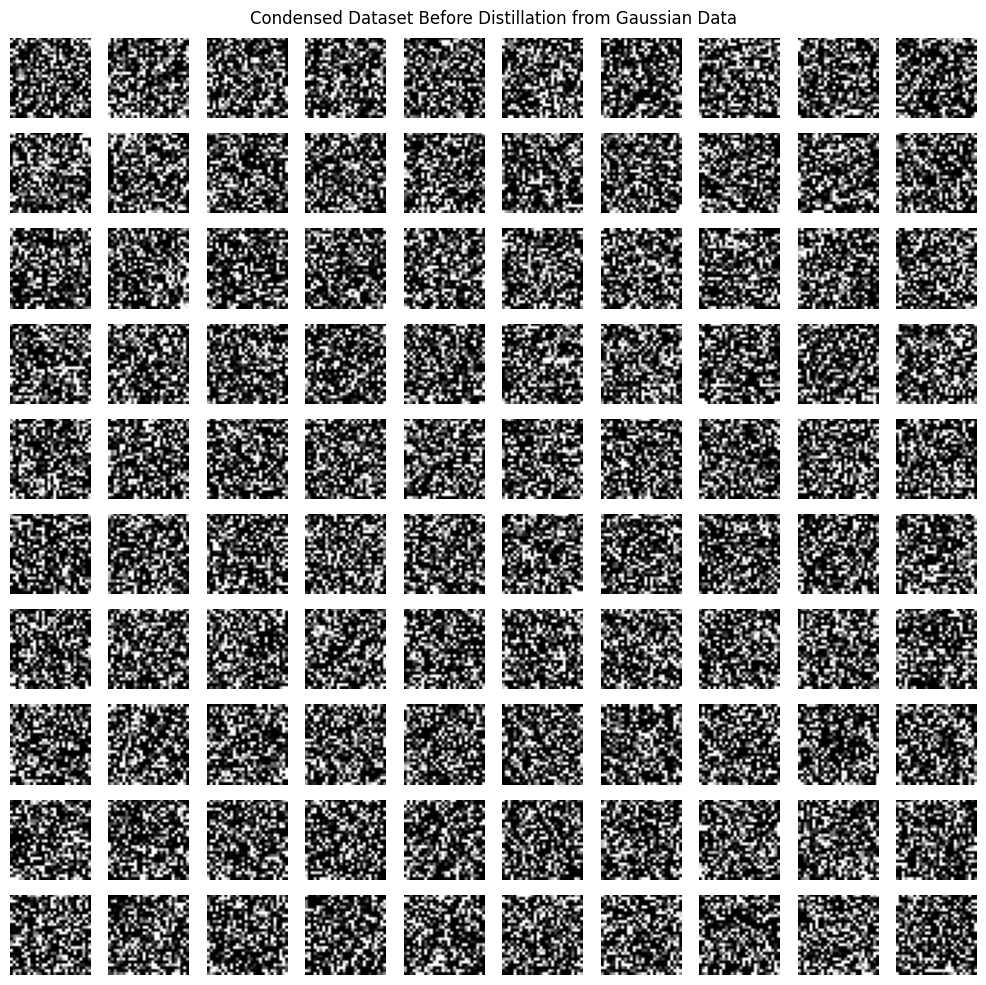

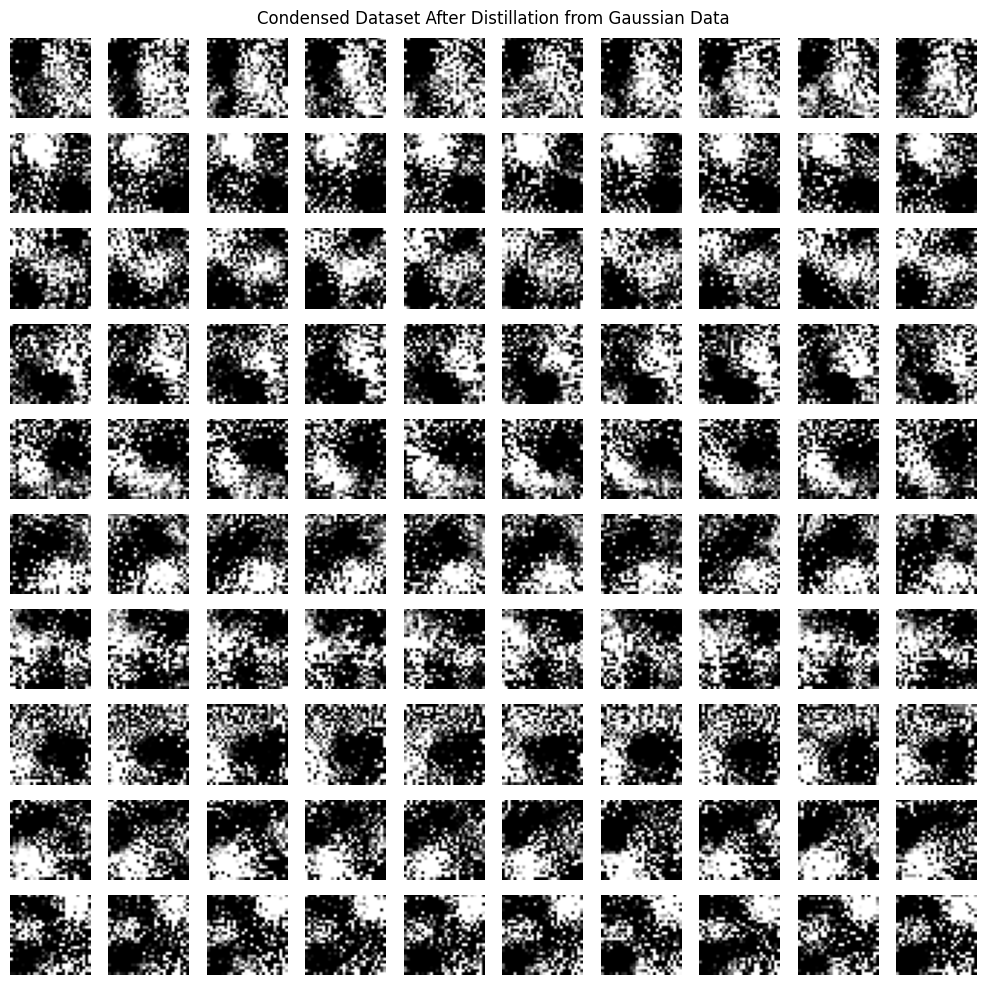

In [8]:
for j in [0, 10]:
    # Create a figure with 10x10 subplots
    fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
    
    # Load the images from the folder
    folder_path = os.path.join(data_path, 'synthetic_dataset_MNIST_gaussian', 'step_' + str(j))
    images = os.listdir(folder_path)
    

    for idx, image in enumerate(images):
        # Open the image
        img = Image.open(os.path.join(folder_path, image))
        
        # Get the row and column indices for the subplot (i.e., 10x10 grid)
        row = idx // 10
        col = idx % 10
        
        # Plot the image in the appropriate subplot
        ax[row, col].imshow(img, cmap='gray')
        ax[row, col].axis('off')  # Hide axis

    # Set the title based on whether it's before or after distillation
    if j == 0:
        fig.suptitle("Condensed Dataset Before Distillation from Gaussian Data")
    else:
        fig.suptitle("Condensed Dataset After Distillation from Gaussian Data")
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [3]:
#MNIST Dataset
data_path = "./Project A/PAD"

#create a folder to save the synthetic dataset
if not os.path.exists(os.path.join(data_path, 'synthetic_dataset_MNIST_real')):
    os.makedirs(os.path.join(data_path, 'synthetic_dataset_MNIST_real'))

#load the dataset
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset("MNIST", data_path)

#define the model   
net = 'ConvNetD3'

Distillator = PAD(device, net, channel, num_classes, im_size, dst_train, os.path.join(data_path,'synthetic_dataset_MNIST_real'), IPC=10, batch_size = 64, M=2,
                 K=100, T=10, eta_S=1, zeta_S=1, eta_theta=0.01, zeta_theta=50, alpha=0, minibatches_size=64)

condensed_dataset = Distillator.train("Real")

Scoring the difficulty of the dataset: 100%|██████████| 60000/60000 [00:29<00:00, 2041.46it/s]
/Data/GRZ/ECE1512_2024F_ProjectRepo_Grzeczkowicz/Project A/PAD.py:101: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  label_syn = torch.tensor([np.ones(self.IPC) * i for i in range(self.num_classes)], dtype=torch.long, requires_grad=False, device=self.device).view(-1)
Training the synthetic data: 100%|██████████| 100/100 [56:34<00:00, 33.94s/it, loss=42] 


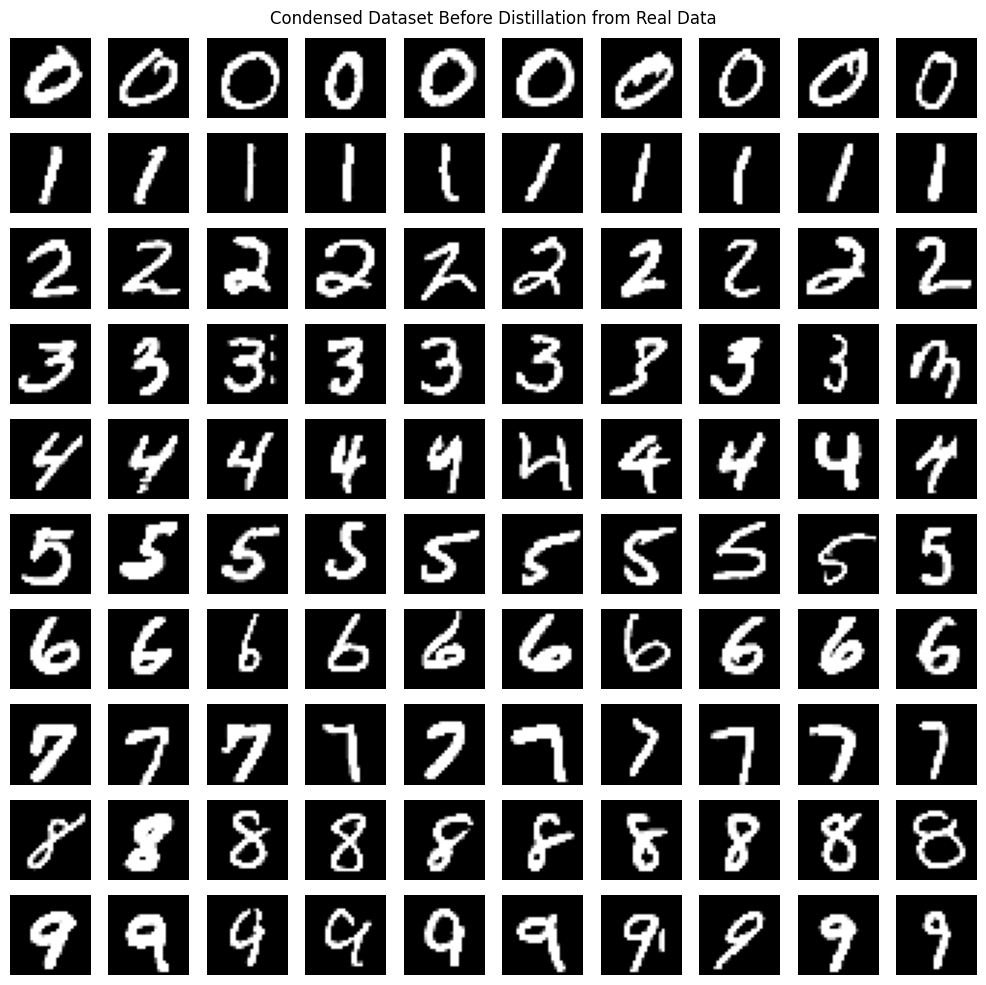

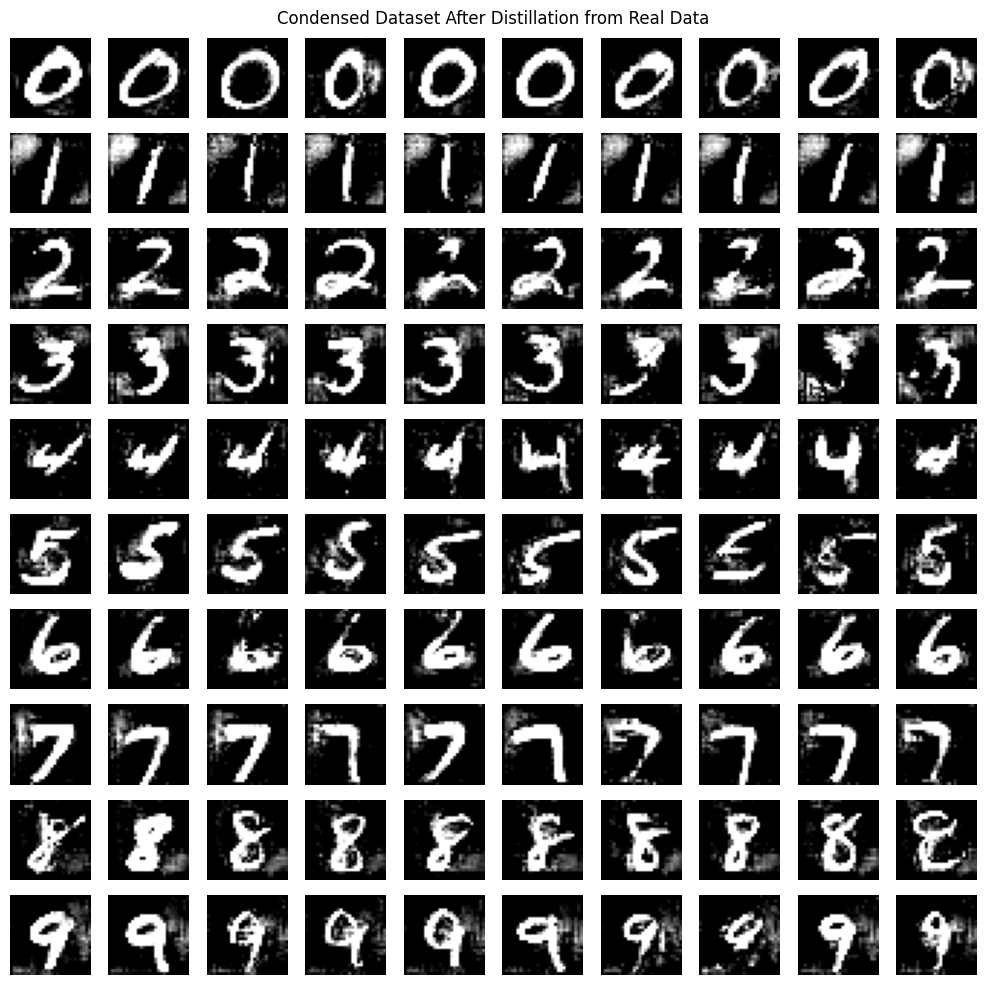

In [4]:
for j in [0, 10]:
    # Create a figure with 10x10 subplots
    fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
    
    # Load the images from the folder
    folder_path = os.path.join(data_path, 'synthetic_dataset_MNIST_real', 'step_' + str(j))
    images = os.listdir(folder_path)
    

    for idx, image in enumerate(images):
        # Open the image
        img = Image.open(os.path.join(folder_path, image))
        
        # Get the row and column indices for the subplot (i.e., 10x10 grid)
        row = idx // 10
        col = idx % 10
        
        # Plot the image in the appropriate subplot
        ax[row, col].imshow(img, cmap='gray')
        ax[row, col].axis('off')  # Hide axis

    # Set the title based on whether it's before or after distillation
    if j == 0:
        fig.suptitle("Condensed Dataset Before Distillation from Real Data")
    else:
        fig.suptitle("Condensed Dataset After Distillation from Real Data")
    
    # Show the plot
    plt.tight_layout()
    plt.show()

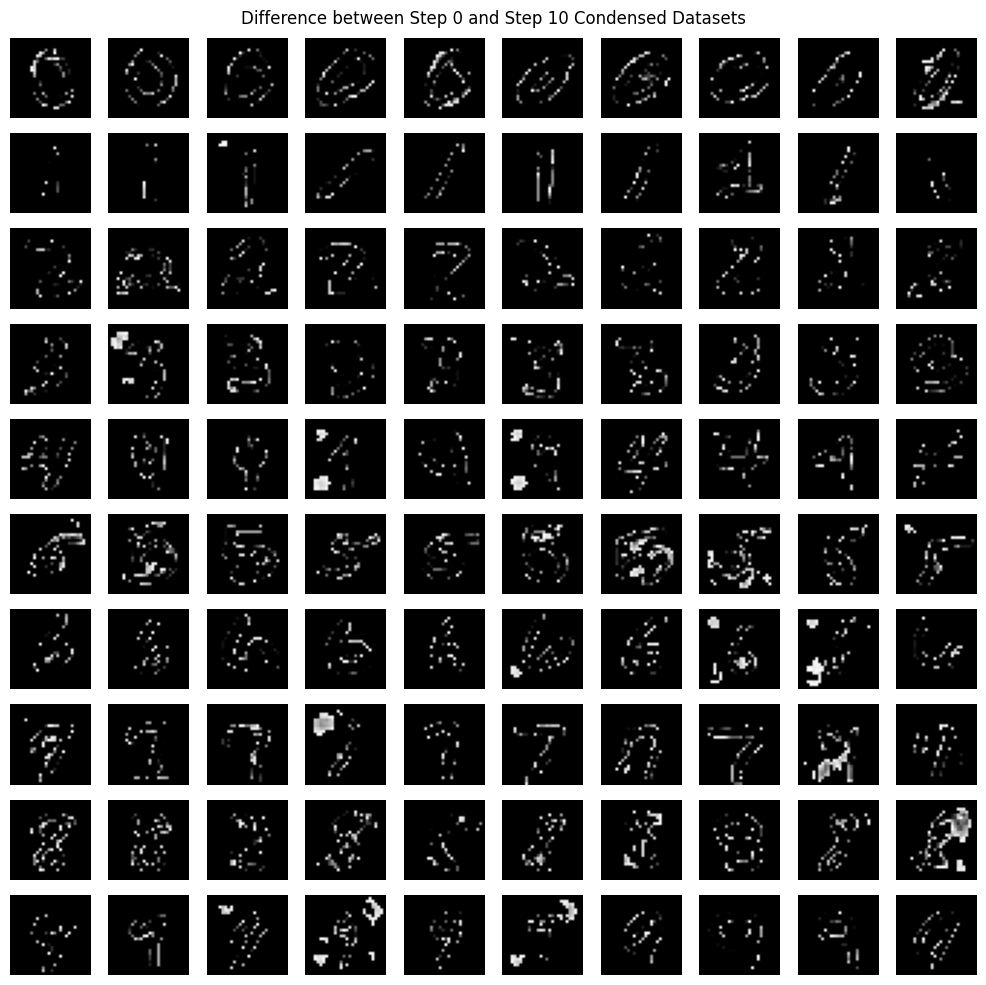

In [5]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

data_path = "./Project A/data"

# Load images from both step 0 and step 10
step_0_folder = os.path.join(data_path, 'synthetic_dataset_MNIST_real', 'step_0')
step_10_folder = os.path.join(data_path, 'synthetic_dataset_MNIST_real', 'step_10')

images_step_0 = os.listdir(step_0_folder)
images_step_10 = os.listdir(step_10_folder)

# Ensure both folders contain the same number of images
assert len(images_step_0) == len(images_step_10), "Mismatch in the number of images between step 0 and step 10."

# Create a figure with 10x10 subplots
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))

# Iterate over the images, compute the difference, and plot them
for idx, (img_0_name, img_10_name) in enumerate(zip(images_step_0, images_step_10)):
    # Open the images from both step 0 and step 10
    img_0 = Image.open(os.path.join(step_0_folder, img_0_name)).convert('L')  # Convert to grayscale
    img_10 = Image.open(os.path.join(step_10_folder, img_10_name)).convert('L')
    
    # Convert the images to numpy arrays
    img_0_np = np.array(img_0)
    img_10_np = np.array(img_10)
    
    # Compute the absolute difference between the two images
    img_diff = np.abs(img_0_np - img_10_np)
    
    # Get the row and column indices for the subplot (i.e., 10x10 grid)
    row = idx // 10
    col = idx % 10
    
    # Plot the difference image in the appropriate subplot
    ax[row, col].imshow(img_diff, cmap='gray')
    ax[row, col].axis('off')  # Hide axis
    
    # Break once 100 images have been plotted (10x10 grid)
    if idx >= 99:
        break

# Set the title for the difference visualization
fig.suptitle("Difference between Step 0 and Step 10 Condensed Datasets")
plt.tight_layout()
plt.show()


### Training on condensed MNIST dataset

In [5]:
#MNIST Dataset
data_path = "./Project A/PAD"

#load the dataset
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset("MNIST", data_path)

#define the model
net = get_network('ConvNetD3', channel, num_classes, im_size)
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
net = train(net, trainloader, criterion, optimizer, device=device, epochs = 50)
#test the model, report accuracy and FLOPs
print("MNIST - Testing on the test dataset after training on the real dataset")
test(net, testloader, criterion, optimizer, device)

Training - Loss: 0.2260 - Accuracy: 0.9528:   2%|▏         | 1/50 [00:08<06:57,  8.52s/it]

Training - Loss: 0.0024 - Accuracy: 0.9999: 100%|██████████| 50/50 [07:01<00:00,  8.43s/it]


MNIST - Testing on the test dataset after training on the real dataset
Accuracy of the network on the test images: 99.49%


In [9]:
folder_path = os.path.join(data_path, 'synthetic_dataset_MNIST_gaussian')
dst_train = []
labels = []
folder_path = os.path.join(data_path, 'synthetic_dataset_MNIST_gaussian', 'step_10')
images = os.listdir(folder_path)
for image in images:
    img = Image.open(os.path.join(folder_path, image))
    label = int(image.split('_')[1].split('.')[0])//10
    img = img.convert('L')
    img = transforms.ToTensor()(img)
    dst_train.append((img, label))

trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
net = get_network('ConvNetD3', channel, num_classes, im_size)
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
net = train(net, trainloader, criterion, optimizer, epochs = 50)
print("MNIST - Testing on the test dataset after training on the condensed dataset computed from Gaussian data")
test(net, testloader, criterion, optimizer, device)


Training - Loss: 0.1420 - Accuracy: 1.0000:   0%|          | 0/50 [00:00<?, ?it/s]

Training - Loss: 0.0249 - Accuracy: 1.0000: 100%|██████████| 50/50 [00:00<00:00, 180.70it/s]


MNIST - Testing on the test dataset after training on the condensed dataset computed from Gaussian data
Accuracy of the network on the test images: 9.27%


In [6]:
folder_path = os.path.join(data_path, 'synthetic_dataset_MNIST_real')
dst_train = []
folder_path = os.path.join(data_path, 'synthetic_dataset_MNIST_real', 'step_10')
images = os.listdir(folder_path)
for image in images:
    img = Image.open(os.path.join(folder_path, image))
    label = int(image.split('_')[1].split('.')[0])//10
    img = img.convert('L')
    img = transforms.ToTensor()(img)
    dst_train.append((img, label))

trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
net = get_network('ConvNetD3', channel, num_classes, im_size)
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
net = train(net, trainloader, criterion, optimizer, epochs = 50)
print("MNIST - Testing on the test dataset after training on the condensed dataset computed from real data")
test(net, testloader, criterion, optimizer, device)


Training - Loss: 1.0406 - Accuracy: 0.8700:   0%|          | 0/50 [00:00<?, ?it/s]

Training - Loss: 0.2756 - Accuracy: 1.0000: 100%|██████████| 50/50 [00:00<00:00, 175.18it/s]


MNIST - Testing on the test dataset after training on the condensed dataset computed from real data
Accuracy of the network on the test images: 91.97999999999999%
